# Toy Train & Eval V2: Complete Test Suite

**Features:**
- ✅ ResNet18 or U-Net 256 선택 가능
- ✅ 전체 시퀀스 or 단일 시퀀스
- ✅ Train/Val split or Overfitting test
- ✅ Sigmoid activation (no dead ReLU)

## 1. Setup & Imports

In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import torchvision.models as models

# Import existing utils
from utils_criterion import compute_errors
from models.unetbaseline_model import define_G  # 기존 모델 그대로 사용

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA RTX A5000


## 2. Locations

In [18]:
locations = [
    "2ndFloorLuxembourg",
    "3rd_Floor_Luxembourg",
    "Attic",
    "Outdoor_Cobblestone_Path",
    "Salle_Chevalier",
    "Salle_des_Colonnes",
    "V119_Cake_Corridors"
]

## 3. Configuration

In [23]:
# ========== Configuration ==========

# Data settings
ROOT_DIR = '/root/dev/data/dataset/Batvision/BatvisionV2/'
USE_ALL_LOCATIONS = True  # True: 전체 시퀀스, False: 단일
LOCATION = 'Salle_des_Colonnes'
MAX_DEPTH = 30.0
IMG_SIZE = 256

# Train/Eval
USE_TRAIN_AS_EVAL = False  # True: overfitting test

# Model settings
MODEL_TYPE = 'unet_256'  # 'resnet' or 'unet_256'
PRETRAINED = True

# Training
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Logging
PRINT_EVERY = 5
VIS_SAMPLES = 3

print("Configuration:")
print(f"  Dataset: {'ALL LOCATIONS' if USE_ALL_LOCATIONS else LOCATION}")
print(f"  Model: {MODEL_TYPE}")
print(f"  Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}")

Configuration:
  Dataset: ALL LOCATIONS
  Model: unet_256
  Epochs: 50, LR: 0.0001


## 4. Dataset Class

In [24]:
class SingleSequenceDataset(Dataset):
    def __init__(self, root_dir, location, csv_file='train.csv', max_depth=30.0, img_size=256):
        self.root_dir = root_dir
        self.location = location
        self.max_depth = max_depth
        self.img_size = img_size
        csv_path = os.path.join(root_dir, location, csv_file)
        self.data = pd.read_csv(csv_path)
        print(f"Loaded {len(self.data)} samples from {location}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        
        # Image
        image_path = os.path.join(self.root_dir, item['camera path'], item['camera file name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        # Depth
        depth_path = os.path.join(self.root_dir, item['depth path'], item['depth file name'])
        depth = np.load(depth_path).astype(np.float32)
        depth = depth / 1000.0
        depth[depth > self.max_depth] = self.max_depth
        depth[depth < 0] = 0
        depth = cv2.resize(depth, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        depth = torch.from_numpy(depth).unsqueeze(0)
        
        return image, depth

# Test
test_loc = LOCATION if not USE_ALL_LOCATIONS else locations[0]
test_ds = SingleSequenceDataset(ROOT_DIR, test_loc, max_depth=MAX_DEPTH, img_size=IMG_SIZE)
print(f"Dataset size: {len(test_ds)}")
img, depth = test_ds[0]
print(f"Image: {img.shape}, Depth: {depth.shape}")

Loaded 431 samples from 2ndFloorLuxembourg
Dataset size: 431
Image: torch.Size([3, 256, 256]), Depth: torch.Size([1, 256, 256])


## 5. Load Train/Eval Data

In [25]:
if USE_ALL_LOCATIONS:
    print(f"\n📦 Loading ALL locations...")
    if USE_TRAIN_AS_EVAL:
        all_datasets = []
        for loc in locations:
            try:
                ds = SingleSequenceDataset(ROOT_DIR, loc, 'train.csv', MAX_DEPTH, IMG_SIZE)
                all_datasets.append(ds)
            except: pass
        train_dataset = eval_dataset = torch.utils.data.ConcatDataset(all_datasets)
    else:
        train_datasets, val_datasets = [], []
        for loc in locations:
            try:
                train_datasets.append(SingleSequenceDataset(ROOT_DIR, loc, 'train.csv', MAX_DEPTH, IMG_SIZE))
                val_datasets.append(SingleSequenceDataset(ROOT_DIR, loc, 'val.csv', MAX_DEPTH, IMG_SIZE))
            except: pass
        train_dataset = torch.utils.data.ConcatDataset(train_datasets)
        eval_dataset = torch.utils.data.ConcatDataset(val_datasets)
else:
    if USE_TRAIN_AS_EVAL:
        train_dataset = eval_dataset = SingleSequenceDataset(ROOT_DIR, LOCATION, 'train.csv', MAX_DEPTH, IMG_SIZE)
    else:
        train_dataset = SingleSequenceDataset(ROOT_DIR, LOCATION, 'train.csv', MAX_DEPTH, IMG_SIZE)
        eval_dataset = SingleSequenceDataset(ROOT_DIR, LOCATION, 'val.csv', MAX_DEPTH, IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f"\nTrain: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Eval: {len(eval_dataset)} samples, {len(eval_loader)} batches")


📦 Loading ALL locations...
Loaded 431 samples from 2ndFloorLuxembourg
Loaded 132 samples from 2ndFloorLuxembourg
Loaded 290 samples from 3rd_Floor_Luxembourg
Loaded 98 samples from 3rd_Floor_Luxembourg
Loaded 37 samples from Attic
Loaded 12 samples from Attic
Loaded 377 samples from Outdoor_Cobblestone_Path
Loaded 125 samples from Outdoor_Cobblestone_Path
Loaded 116 samples from Salle_Chevalier
Loaded 40 samples from Salle_Chevalier
Loaded 240 samples from Salle_des_Colonnes
Loaded 80 samples from Salle_des_Colonnes
Loaded 420 samples from V119_Cake_Corridors
Loaded 138 samples from V119_Cake_Corridors

Train: 1911 samples, 239 batches
Eval: 625 samples, 79 batches


## 6. Model Definition

In [ ]:
class SimpleDepthModel(nn.Module):
    """ResNet18-based depth model for toy testing"""
    def __init__(self, pretrained=True, max_depth=30.0):
        super().__init__()
        self.max_depth = max_depth
        resnet = models.resnet18(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(True), nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(True), nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(True), nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(True), nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(True), nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 1, 3, padding=1),
        )
    
    def forward(self, x):
        return torch.sigmoid(self.decoder(self.encoder(x))) * self.max_depth


# Mock config for unetbaseline_model
class MockCfg:
    class dataset:
        depth_norm = True  # unetbaseline_model.py 기본 설정
        max_depth = MAX_DEPTH


# Create model
if MODEL_TYPE == 'resnet':
    model = SimpleDepthModel(PRETRAINED, MAX_DEPTH)
    print(f"\n✅ Created ResNet18 model (toy baseline)")
    
elif MODEL_TYPE == 'unet_256':
    # 기존 unetbaseline_model.py의 define_G를 그대로 사용
    cfg = MockCfg()
    model = define_G(
        cfg=cfg,
        input_nc=3,      # RGB image
        output_nc=1,     # Depth map
        ngf=64,          # Number of filters
        netG='unet_256', # U-Net 256x256
        norm='batch',
        use_dropout=False,
        init_type='normal',
        init_gain=0.02,
        gpu_ids=[]       # CPU mode, will move to GPU later
    )
    print(f"\n✅ Created U-Net 256 (unetbaseline_model.py - original)")
    print(f"   depth_norm={cfg.dataset.depth_norm}")
    
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}")

model = model.to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    test_output = model(test_input)
    print(f"Test - Input: {test_input.shape}, Output: {test_output.shape}")
    print(f"Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")
    
    if MODEL_TYPE == 'unet_256' and cfg.dataset.depth_norm:
        print(f"Note: Output is normalized [0, 1], will be denormalized during training")

initialize network with normal

✅ Created U-Net 256 (unetbaseline_model.py - original)
   depth_norm=True
Parameters: 54,409,857
Test - Input: torch.Size([1, 3, 256, 256]), Output: torch.Size([1, 1, 256, 256])
Output range: [-0.948, 0.780]
Note: Output is normalized [0, 1], will be denormalized during training


## 7. Training Setup

In [27]:
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 5, verbose=True)
print("Training setup complete")

Training setup complete


/opt/conda/envs/evtAnything/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 8. Training Loop

In [28]:
history = {'train_loss': [], 'eval_loss': [], 'eval_abs_rel': [], 'eval_rmse': [], 'eval_delta1': []}

print("="*80)
print("Training Started")
print("="*80)

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_losses = []
    for images, depths in train_loader:
        images, depths = images.to(device), depths.to(device)
        pred = model(images)
        mask = depths > 0
        loss = criterion(pred[mask], depths[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Eval
    model.eval()
    eval_losses, all_errors = [], []
    with torch.no_grad():
        for images, depths in eval_loader:
            images, depths = images.to(device), depths.to(device)
            pred = model(images)
            mask = depths > 0
            eval_losses.append(criterion(pred[mask], depths[mask]).item())
            for i in range(images.size(0)):
                gt = depths[i].squeeze().cpu().numpy()
                pr = np.clip(pred[i].squeeze().cpu().numpy(), 0, MAX_DEPTH)
                all_errors.append(compute_errors(gt, pr, 0.0))
    
    train_loss = np.mean(train_losses)
    eval_loss = np.mean(eval_losses)
    errors = np.array(all_errors).mean(0)
    abs_rel, rmse, delta1 = errors[0], errors[1], errors[2]
    
    history['train_loss'].append(train_loss)
    history['eval_loss'].append(eval_loss)
    history['eval_abs_rel'].append(abs_rel)
    history['eval_rmse'].append(rmse)
    history['eval_delta1'].append(delta1)
    
    scheduler.step(eval_loss)
    
    if (epoch + 1) % PRINT_EVERY == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Loss={train_loss:.4f}/{eval_loss:.4f}, ABS_REL={abs_rel:.4f}, Delta1={delta1:.4f}")

print("\n" + "="*80)
print(f"Final: ABS_REL={history['eval_abs_rel'][-1]:.4f}, RMSE={history['eval_rmse'][-1]:.4f}, Delta1={history['eval_delta1'][-1]:.4f}")
print("="*80)

Training Started
Epoch 1/50: Loss=1.1234/1.3133, ABS_REL=0.4208, Delta1=0.4279
Epoch 5/50: Loss=0.4870/0.9677, ABS_REL=0.3649, Delta1=0.5441
Epoch 10/50: Loss=0.2886/0.8799, ABS_REL=0.3032, Delta1=0.5917
Epoch 15/50: Loss=0.2325/0.9056, ABS_REL=0.3260, Delta1=0.5884
Epoch 20/50: Loss=0.1926/0.8589, ABS_REL=0.2894, Delta1=0.6096
Epoch 25/50: Loss=0.1718/0.8507, ABS_REL=0.2914, Delta1=0.6116
Epoch 30/50: Loss=0.1514/0.8495, ABS_REL=0.2957, Delta1=0.6168
Epoch 35/50: Loss=0.1159/0.8553, ABS_REL=0.3077, Delta1=0.6159
Epoch 40/50: Loss=0.1043/0.8453, ABS_REL=0.3142, Delta1=0.6178
Epoch 45/50: Loss=0.0970/0.8443, ABS_REL=0.3043, Delta1=0.6198
Epoch 50/50: Loss=0.0910/0.8464, ABS_REL=0.3122, Delta1=0.6175

Final: ABS_REL=0.3122, RMSE=1.8545, Delta1=0.6175


## 9. Visualization

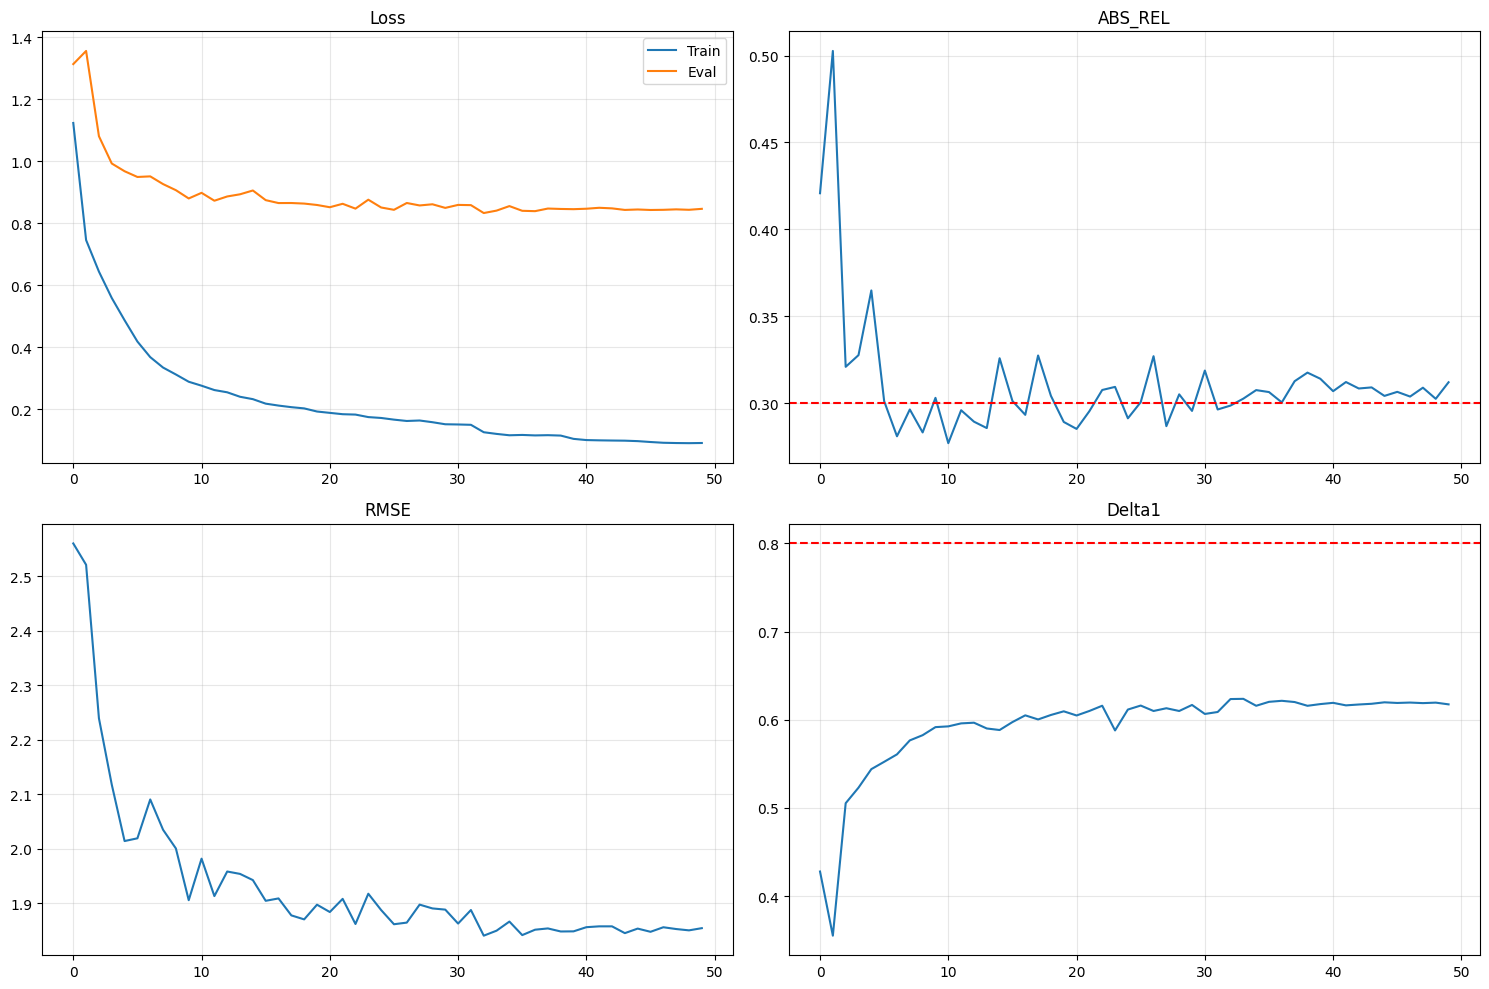

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].plot(history['train_loss'], label='Train')
axes[0,0].plot(history['eval_loss'], label='Eval')
axes[0,0].set_title('Loss')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(history['eval_abs_rel'])
axes[0,1].set_title('ABS_REL')
axes[0,1].axhline(0.3, color='r', linestyle='--')
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(history['eval_rmse'])
axes[1,0].set_title('RMSE')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(history['eval_delta1'])
axes[1,1].set_title('Delta1')
axes[1,1].axhline(0.8, color='r', linestyle='--')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()